In [224]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [225]:
import sys
sys.path.append('..')
import functools
import math

import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol_seq

import bvbq_torch

In [226]:
mixmeans_test = torch.tensor([[  1.8033],
                           [ -1.4296],
                           [ -1.9691],
                           [  1.2147],
                           [ -6.9166],
                           [-11.5672],
                           [ -1.5860],
                           [ -4.3302],
                           [  8.7410],
                           [ -1.3793],
                           [ -4.8774],
                           [  2.3949]])
mixvars_test = torch.ones((12,1))
mixweights_test = torch.ones(12)/12

In [227]:
def logprob_mixgaussians(x):
    return bvbq_torch.distributions.MixtureDiagonalNormalDistribution.logprob_(
                        x,mixmeans_test,mixvars_test,mixweights_test).reshape(-1,1)
def logprob_t(x,nu):
    normalizer = jax.scipy.special.gammaln((nu+1)/2) \
                 -jax.scipy.special.gammaln(nu/2) \
                 -0.5*jnp.log(jnp.pi*nu)
    main_term = -(nu+1)/2*jnp.log(1+x**2/nu)
    return main_term + normalizer

xdata = torch.linspace(-20,20,51).reshape(-1,1)
ydata = logprob_mixgaussians(xdata)
logprobgp = bvbq_torch.gp.SimpleGP(1,kind='smatern52',noise=0,zeromax=True)
logprobgp.mean = -30.0
logprobgp.fix_mean()
logprobgp.fix_noise()
logprobgp.set_data(xdata,ydata,empirical_params=False)
# logprobgp.optimize_params(tol=1e-1)

In [228]:
logprobgp.mean

tensor(-30.)

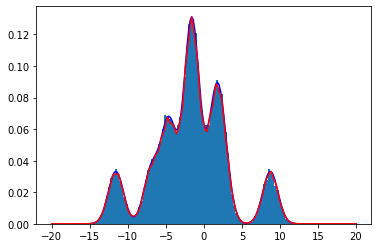

In [229]:
xplot = np.linspace(-20,20,201).reshape(-1,1)
yplot1 = logprob_mixgaussians(xplot).detach().numpy()
# yplot1 = logprob_t(xplot,2.5)
yplot2 = logprobgp.predict(xplot,return_cov=False).detach().numpy()
plt.plot(xplot,np.exp(yplot1),'b')
plt.plot(xplot,np.exp(yplot2),'r')
samples1 = bvbq_torch.distributions.MixtureDiagonalNormalDistribution.sample_(100000,
                                                             mixmeans_test,
                                                             mixvars_test,
                                                             mixweights_test).detach().numpy()
plt.hist(samples1.flatten(),density=True,bins=100);

In [230]:
bvbq_torch.distributions.DiagonalNormalDistribution.sample_

<function bvbq_torch.distributions.DiagonalNormalDistribution.sample_(n, mean, var)>

In [231]:
nmixtures = 3
ndim = 1
mixmeans = torch.randn(nmixtures,1)
mixvars = torch.distributions.HalfNormal(1.0).sample((nmixtures,1))
mixweights = torch.distributions.Dirichlet(torch.ones(nmixtures)).sample()
mean = torch.randn((1,))
var = torch.distributions.HalfNormal(1.0).sample((1,))

In [ ]:
alpha_relbo = 1e-1
maxiter_relbo = 300
alpha_boost = 1e-1
maxiter_boost = 100
maxiter = 20

mixmeans = torch.zeros(1,ndim)
mixvars = (20.0/3)**2*torch.ones(1,ndim)
mixweights = torch.ones(1)
for k in range(maxiter):
    mean,var = bvbq_torch.bvbq.propose_component_mvn_mixmvn_relbo(
                logprobgp,mixmeans,mixvars,mixweights)
    mixmeans,mixvars,mixweights = bvbq_torch.bvbq.update_distribution_mvn_mixmvn(
                                            logprobgp,
                                            mean,var,
                                            mixmeans,mixvars,
                                            mixweights,
                                            lr=1e-1/(k+1),
                                            weight_delta=1e-6,
                                            decaying_lr=False)

    print(mixmeans[-1],mixvars[-1],mixweights[-1])
mixmeans,mixvars,mixweights = bvbq_torch.utils.cut_components_mixmvn(mixmeans,mixvars,mixweights)
distrib = bvbq_torch.distributions.MixtureDiagonalNormalDistribution(mixmeans,mixvars,mixweights)

tensor([8.9507]) tensor([0.5494]) tensor(0.1142)
tensor([-2.9762]) tensor([4.5245]) tensor(0.7918)
tensor([1.9498]) tensor([1.9888]) tensor(0.2381)
tensor([0.3521]) tensor([3.6890]) tensor(0.1292)


In [222]:
mixmeans_fit,mixvars_fit,mixweights_fit = bvbq_torch.bvbq.reweight_mixmvn_elbo(
                logprobgp,mixmeans,mixvars,mixweights,nsamples=1000,lr=1e-1,
                optim=torch.optim.SGD,maxiter=1000)
distrib_fit = bvbq_torch.distributions.MixtureDiagonalNormalDistribution(
                mixmeans_fit,mixvars_fit,mixweights_fit)

tensor([-2.6724, -0.7673, -2.6690, -2.6484, -2.4601, -2.8164, -3.8001, -3.0744,
        -3.0912, -3.5897, -4.6380, -3.5557, -5.6450, -3.5768, -3.6984, -4.1795,
        -4.5126, -4.2564, -5.5587], requires_grad=True)
tensor([0.0668, 0.3814, 0.0670, 0.0684, 0.0820, 0.0581, 0.0221, 0.0452, 0.0444,
        0.0272, 0.0096, 0.0282, 0.0035, 0.0276, 0.0245, 0.0152, 0.0109, 0.0141,
        0.0038], grad_fn=<AddBackward0>)
tensor([0.0668, 0.3814, 0.0670, 0.0684, 0.0820, 0.0581, 0.0221, 0.0452, 0.0444,
        0.0272, 0.0096, 0.0282, 0.0035, 0.0276, 0.0245, 0.0152, 0.0109, 0.0141,
        0.0038], grad_fn=<DivBackward0>)
0 tensor(-2.1522, grad_fn=<AddBackward0>)
tensor([-2.6813, -0.7526, -2.6766, -2.6487, -2.4611, -2.8146, -3.7994, -3.0732,
        -3.0959, -3.5894, -4.6378, -3.5549, -5.6450, -3.5762, -3.6976, -4.1791,
        -4.5125, -4.2580, -5.5586], requires_grad=True)
tensor([0.0662, 0.3860, 0.0665, 0.0684, 0.0819, 0.0582, 0.0221, 0.0452, 0.0442,
        0.0272, 0.0096, 0.0282, 0.0035, 0.02

44 tensor(-2.1776, grad_fn=<AddBackward0>)
tensor([-2.9948, -0.1746, -2.9610, -2.6791, -2.5087, -2.7515, -3.7765, -3.0499,
        -3.2682, -3.5811, -4.6365, -3.5284, -5.6464, -3.5689, -3.6691, -4.1651,
        -4.5108, -4.3182, -5.5561], requires_grad=True)
tensor([0.0488, 0.6096, 0.0505, 0.0664, 0.0782, 0.0619, 0.0226, 0.0463, 0.0374,
        0.0275, 0.0096, 0.0289, 0.0035, 0.0278, 0.0252, 0.0154, 0.0109, 0.0132,
        0.0039], grad_fn=<AddBackward0>)
tensor([0.0411, 0.5133, 0.0425, 0.0559, 0.0659, 0.0521, 0.0191, 0.0390, 0.0315,
        0.0231, 0.0081, 0.0244, 0.0030, 0.0234, 0.0212, 0.0130, 0.0092, 0.0111,
        0.0032], grad_fn=<DivBackward0>)
45 tensor(-2.1932, grad_fn=<AddBackward0>)
tensor([-3.0005, -0.1628, -2.9663, -2.6798, -2.5107, -2.7506, -3.7762, -3.0494,
        -3.2714, -3.5812, -4.6364, -3.5281, -5.6465, -3.5687, -3.6686, -4.1649,
        -4.5108, -4.3194, -5.5560], requires_grad=True)
tensor([0.0486, 0.6151, 0.0502, 0.0663, 0.0781, 0.0619, 0.0227, 0.0463, 0.0372,


tensor([0.0374, 0.9253, 0.0394, 0.0627, 0.0716, 0.0643, 0.0230, 0.0465, 0.0317,
        0.0273, 0.0096, 0.0293, 0.0035, 0.0277, 0.0257, 0.0155, 0.0109, 0.0124,
        0.0039], grad_fn=<AddBackward0>)
tensor([0.0255, 0.6305, 0.0269, 0.0427, 0.0488, 0.0438, 0.0156, 0.0317, 0.0216,
        0.0186, 0.0066, 0.0200, 0.0024, 0.0189, 0.0175, 0.0106, 0.0074, 0.0085,
        0.0026], grad_fn=<DivBackward0>)
102 tensor(-2.2149, grad_fn=<AddBackward0>)
tensor([-3.2708,  0.4291, -3.2170, -2.7397, -2.6023, -2.7109, -3.7627, -3.0455,
        -3.4397, -3.5863, -4.6394, -3.5137, -5.6499, -3.5736, -3.6501, -4.1575,
        -4.5146, -4.3847, -5.5552], requires_grad=True)
tensor([0.0373, 0.9305, 0.0393, 0.0626, 0.0715, 0.0644, 0.0230, 0.0465, 0.0316,
        0.0273, 0.0096, 0.0294, 0.0035, 0.0277, 0.0257, 0.0155, 0.0109, 0.0124,
        0.0039], grad_fn=<AddBackward0>)
tensor([0.0253, 0.6320, 0.0267, 0.0425, 0.0486, 0.0437, 0.0156, 0.0316, 0.0214,
        0.0186, 0.0065, 0.0199, 0.0024, 0.0188, 0.0174, 0

tensor([-3.4706,  0.8919, -3.4050, -2.8065, -2.6898, -2.6929, -3.7571, -3.0550,
        -3.5738, -3.5983, -4.6448, -3.5091, -5.6538, -3.5857, -3.6407, -4.1554,
        -4.5208, -4.4411, -5.5555], requires_grad=True)
tensor([0.0306, 1.2354, 0.0327, 0.0587, 0.0657, 0.0655, 0.0231, 0.0460, 0.0277,
        0.0270, 0.0096, 0.0295, 0.0035, 0.0273, 0.0259, 0.0156, 0.0108, 0.0117,
        0.0039], grad_fn=<AddBackward0>)
tensor([0.0175, 0.7059, 0.0187, 0.0335, 0.0375, 0.0374, 0.0132, 0.0263, 0.0158,
        0.0154, 0.0055, 0.0168, 0.0020, 0.0156, 0.0148, 0.0089, 0.0062, 0.0067,
        0.0022], grad_fn=<DivBackward0>)
163 tensor(-2.2033, grad_fn=<AddBackward0>)
tensor([-3.4732,  0.8991, -3.4079, -2.8078, -2.6916, -2.6927, -3.7571, -3.0552,
        -3.5758, -3.5986, -4.6449, -3.5090, -5.6539, -3.5860, -3.6406, -4.1554,
        -4.5210, -4.4419, -5.5555], requires_grad=True)
tensor([0.0305, 1.2405, 0.0326, 0.0586, 0.0656, 0.0655, 0.0231, 0.0460, 0.0276,
        0.0270, 0.0096, 0.0295, 0.0035, 0.

tensor([0.0133, 0.7510, 0.0143, 0.0279, 0.0307, 0.0332, 0.0117, 0.0229, 0.0126,
        0.0134, 0.0048, 0.0149, 0.0018, 0.0136, 0.0131, 0.0078, 0.0054, 0.0056,
        0.0019], grad_fn=<DivBackward0>)
222 tensor(-2.2598, grad_fn=<AddBackward0>)
tensor([-3.6202,  1.2404, -3.5487, -2.8654, -2.7680, -2.6851, -3.7552, -3.0690,
        -3.6789, -3.6117, -4.6506, -3.5088, -5.6575, -3.5995, -3.6359, -4.1555,
        -4.5275, -4.4892, -5.5563], requires_grad=True)
tensor([0.0264, 1.4945, 0.0284, 0.0554, 0.0609, 0.0660, 0.0231, 0.0454, 0.0249,
        0.0266, 0.0095, 0.0295, 0.0035, 0.0270, 0.0260, 0.0156, 0.0107, 0.0112,
        0.0039], grad_fn=<AddBackward0>)
tensor([0.0133, 0.7516, 0.0143, 0.0279, 0.0306, 0.0332, 0.0116, 0.0228, 0.0125,
        0.0134, 0.0048, 0.0148, 0.0018, 0.0136, 0.0131, 0.0078, 0.0054, 0.0056,
        0.0019], grad_fn=<DivBackward0>)
223 tensor(-2.2550, grad_fn=<AddBackward0>)
tensor([-3.6223,  1.2456, -3.5507, -2.8666, -2.7694, -2.6850, -3.7552, -3.0693,
        -3.68

277 tensor(-2.2614, grad_fn=<AddBackward0>)
tensor([-3.7299,  1.4969, -3.6531, -2.9181, -2.8338, -2.6830, -3.7552, -3.0838,
        -3.7582, -3.6244, -4.6561, -3.5107, -5.6609, -3.6127, -3.6337, -4.1567,
        -4.5338, -4.5268, -5.5572], requires_grad=True)
tensor([0.0237, 1.6989, 0.0256, 0.0526, 0.0571, 0.0661, 0.0231, 0.0448, 0.0231,
        0.0263, 0.0095, 0.0294, 0.0035, 0.0266, 0.0261, 0.0155, 0.0107, 0.0108,
        0.0039], grad_fn=<AddBackward0>)
tensor([0.0109, 0.7803, 0.0117, 0.0242, 0.0262, 0.0304, 0.0106, 0.0206, 0.0106,
        0.0121, 0.0043, 0.0135, 0.0016, 0.0122, 0.0120, 0.0071, 0.0049, 0.0049,
        0.0018], grad_fn=<DivBackward0>)
278 tensor(-2.2583, grad_fn=<AddBackward0>)
tensor([-3.7318,  1.5012, -3.6549, -2.9189, -2.8348, -2.6829, -3.7552, -3.0841,
        -3.7598, -3.6246, -4.6562, -3.5107, -5.6610, -3.6130, -3.6337, -4.1567,
        -4.5339, -4.5275, -5.5572], requires_grad=True)
tensor([0.0237, 1.7024, 0.0255, 0.0526, 0.0571, 0.0661, 0.0231, 0.0448, 0.0230

335 tensor(-2.2812, grad_fn=<AddBackward0>)
tensor([-3.8260,  1.7217, -3.7479, -2.9677, -2.8961, -2.6836, -3.7562, -3.0995,
        -3.8310, -3.6378, -4.6617, -3.5136, -5.6643, -3.6264, -3.6326, -4.1584,
        -4.5403, -4.5627, -5.5582], requires_grad=True)
tensor([0.0216, 1.8862, 0.0233, 0.0501, 0.0538, 0.0661, 0.0231, 0.0441, 0.0215,
        0.0260, 0.0094, 0.0294, 0.0035, 0.0263, 0.0261, 0.0155, 0.0106, 0.0104,
        0.0038], grad_fn=<AddBackward0>)
tensor([0.0092, 0.8024, 0.0099, 0.0213, 0.0229, 0.0281, 0.0098, 0.0188, 0.0091,
        0.0110, 0.0040, 0.0125, 0.0015, 0.0112, 0.0111, 0.0066, 0.0045, 0.0044,
        0.0016], grad_fn=<DivBackward0>)
336 tensor(-2.2659, grad_fn=<AddBackward0>)
tensor([-3.8275,  1.7255, -3.7495, -2.9686, -2.8972, -2.6836, -3.7562, -3.0998,
        -3.8324, -3.6380, -4.6618, -3.5137, -5.6644, -3.6266, -3.6326, -4.1585,
        -4.5404, -4.5634, -5.5583], requires_grad=True)
tensor([0.0215, 1.8894, 0.0233, 0.0501, 0.0537, 0.0661, 0.0231, 0.0441, 0.0214

388 tensor(-2.3068, grad_fn=<AddBackward0>)
tensor([-3.9018,  1.8988, -3.8233, -3.0097, -2.9480, -2.6859, -3.7576, -3.1135,
        -3.8921, -3.6498, -4.6667, -3.5169, -5.6673, -3.6384, -3.6323, -4.1603,
        -4.5461, -4.5937, -5.5592], requires_grad=True)
tensor([0.0200, 2.0384, 0.0216, 0.0481, 0.0511, 0.0659, 0.0231, 0.0435, 0.0202,
        0.0257, 0.0094, 0.0293, 0.0035, 0.0260, 0.0261, 0.0155, 0.0106, 0.0101,
        0.0038], grad_fn=<AddBackward0>)
tensor([0.0080, 0.8181, 0.0087, 0.0193, 0.0205, 0.0265, 0.0093, 0.0175, 0.0081,
        0.0103, 0.0038, 0.0117, 0.0014, 0.0104, 0.0105, 0.0062, 0.0042, 0.0040,
        0.0015], grad_fn=<DivBackward0>)
389 tensor(-2.2815, grad_fn=<AddBackward0>)
tensor([-3.9031,  1.9019, -3.8246, -3.0103, -2.9490, -2.6860, -3.7577, -3.1137,
        -3.8933, -3.6500, -4.6667, -3.5169, -5.6674, -3.6386, -3.6324, -4.1604,
        -4.5462, -4.5942, -5.5592], requires_grad=True)
tensor([0.0200, 2.0411, 0.0216, 0.0481, 0.0511, 0.0659, 0.0231, 0.0435, 0.0202

442 tensor(-2.2784, grad_fn=<AddBackward0>)
tensor([-3.9698,  2.0541, -3.8895, -3.0483, -2.9960, -2.6894, -3.7594, -3.1276,
        -3.9470, -3.6616, -4.6716, -3.5205, -5.6702, -3.6502, -3.6326, -4.1625,
        -4.5518, -4.6216, -5.5602], requires_grad=True)
tensor([0.0187, 2.1747, 0.0202, 0.0463, 0.0488, 0.0657, 0.0230, 0.0429, 0.0191,
        0.0254, 0.0093, 0.0292, 0.0034, 0.0257, 0.0261, 0.0154, 0.0105, 0.0098,
        0.0038], grad_fn=<AddBackward0>)
tensor([0.0071, 0.8306, 0.0077, 0.0177, 0.0186, 0.0251, 0.0088, 0.0164, 0.0073,
        0.0097, 0.0036, 0.0111, 0.0013, 0.0098, 0.0100, 0.0059, 0.0040, 0.0037,
        0.0015], grad_fn=<DivBackward0>)
443 tensor(-2.2853, grad_fn=<AddBackward0>)
tensor([-3.9710,  2.0571, -3.8910, -3.0488, -2.9969, -2.6894, -3.7595, -3.1278,
        -3.9483, -3.6618, -4.6716, -3.5206, -5.6703, -3.6504, -3.6326, -4.1625,
        -4.5519, -4.6223, -5.5602], requires_grad=True)
tensor([0.0187, 2.1774, 0.0202, 0.0463, 0.0487, 0.0657, 0.0230, 0.0429, 0.0191

499 tensor(-2.2839, grad_fn=<AddBackward0>)
tensor([-4.0350,  2.2027, -3.9551, -3.0864, -3.0439, -2.6939, -3.7617, -3.1419,
        -4.0012, -3.6740, -4.6765, -3.5247, -5.6733, -3.6622, -3.6333, -4.1649,
        -4.5578, -4.6504, -5.5612], requires_grad=True)
tensor([0.0175, 2.3075, 0.0190, 0.0447, 0.0465, 0.0654, 0.0230, 0.0423, 0.0181,
        0.0251, 0.0093, 0.0290, 0.0034, 0.0254, 0.0261, 0.0154, 0.0104, 0.0095,
        0.0038], grad_fn=<AddBackward0>)
tensor([0.0064, 0.8417, 0.0069, 0.0163, 0.0170, 0.0239, 0.0084, 0.0154, 0.0066,
        0.0091, 0.0034, 0.0106, 0.0013, 0.0092, 0.0095, 0.0056, 0.0038, 0.0035,
        0.0014], grad_fn=<DivBackward0>)
500 tensor(-2.2704, grad_fn=<AddBackward0>)
tensor([-4.0362,  2.2054, -3.9564, -3.0870, -3.0446, -2.6940, -3.7617, -3.1422,
        -4.0025, -3.6742, -4.6766, -3.5247, -5.6734, -3.6624, -3.6333, -4.1649,
        -4.5579, -4.6512, -5.5613], requires_grad=True)
tensor([0.0175, 2.3100, 0.0190, 0.0446, 0.0465, 0.0654, 0.0230, 0.0423, 0.0181

556 tensor(-2.3154, grad_fn=<AddBackward0>)
tensor([-4.0949,  2.3363, -4.0132, -3.1234, -3.0864, -2.6981, -3.7638, -3.1571,
        -4.0532, -3.6853, -4.6817, -3.5288, -5.6761, -3.6746, -3.6340, -4.1672,
        -4.5633, -4.6785, -5.5624], requires_grad=True)
tensor([0.0165, 2.4285, 0.0179, 0.0431, 0.0447, 0.0652, 0.0229, 0.0417, 0.0172,
        0.0248, 0.0092, 0.0289, 0.0034, 0.0250, 0.0261, 0.0154, 0.0104, 0.0093,
        0.0038], grad_fn=<AddBackward0>)
tensor([0.0058, 0.8509, 0.0063, 0.0151, 0.0156, 0.0228, 0.0080, 0.0146, 0.0060,
        0.0087, 0.0032, 0.0101, 0.0012, 0.0088, 0.0091, 0.0054, 0.0036, 0.0032,
        0.0013], grad_fn=<DivBackward0>)
557 tensor(-2.2965, grad_fn=<AddBackward0>)
tensor([-4.0959,  2.3386, -4.0141, -3.1239, -3.0872, -2.6982, -3.7638, -3.1574,
        -4.0546, -3.6855, -4.6818, -3.5288, -5.6762, -3.6747, -3.6340, -4.1672,
        -4.5634, -4.6791, -5.5624], requires_grad=True)
tensor([0.0165, 2.4307, 0.0179, 0.0430, 0.0446, 0.0652, 0.0229, 0.0417, 0.0172

tensor([0.0053, 0.8589, 0.0057, 0.0141, 0.0145, 0.0219, 0.0077, 0.0139, 0.0056,
        0.0083, 0.0031, 0.0097, 0.0012, 0.0084, 0.0088, 0.0052, 0.0035, 0.0030,
        0.0013], grad_fn=<DivBackward0>)
615 tensor(-2.3182, grad_fn=<AddBackward0>)
tensor([-4.1505,  2.4605, -4.0680, -3.1595, -3.1286, -2.7030, -3.7662, -3.1725,
        -4.1012, -3.6968, -4.6869, -3.5332, -5.6790, -3.6870, -3.6350, -4.1697,
        -4.5690, -4.7051, -5.5635], requires_grad=True)
tensor([0.0156, 2.5425, 0.0170, 0.0416, 0.0428, 0.0649, 0.0229, 0.0410, 0.0164,
        0.0245, 0.0092, 0.0288, 0.0034, 0.0247, 0.0260, 0.0153, 0.0103, 0.0090,
        0.0038], grad_fn=<AddBackward0>)
tensor([0.0053, 0.8590, 0.0057, 0.0140, 0.0145, 0.0219, 0.0077, 0.0139, 0.0055,
        0.0083, 0.0031, 0.0097, 0.0012, 0.0084, 0.0088, 0.0052, 0.0035, 0.0030,
        0.0013], grad_fn=<DivBackward0>)
616 tensor(-2.3057, grad_fn=<AddBackward0>)
tensor([-4.1514,  2.4626, -4.0688, -3.1602, -3.1293, -2.7031, -3.7662, -3.1728,
        -4.10

674 tensor(-2.3671, grad_fn=<AddBackward0>)
tensor([-4.2006,  2.5714, -4.1173, -3.1930, -3.1674, -2.7086, -3.7687, -3.1870,
        -4.1437, -3.7080, -4.6919, -3.5377, -5.6817, -3.6988, -3.6363, -4.1722,
        -4.5745, -4.7293, -5.5647], requires_grad=True)
tensor([0.0149, 2.6450, 0.0162, 0.0402, 0.0413, 0.0645, 0.0228, 0.0405, 0.0157,
        0.0242, 0.0091, 0.0287, 0.0034, 0.0245, 0.0260, 0.0153, 0.0103, 0.0088,
        0.0038], grad_fn=<AddBackward0>)
tensor([0.0049, 0.8658, 0.0053, 0.0132, 0.0135, 0.0211, 0.0075, 0.0132, 0.0052,
        0.0079, 0.0030, 0.0094, 0.0011, 0.0080, 0.0085, 0.0050, 0.0034, 0.0029,
        0.0013], grad_fn=<DivBackward0>)
675 tensor(-2.2692, grad_fn=<AddBackward0>)
tensor([-4.2016,  2.5734, -4.1183, -3.1937, -3.1680, -2.7086, -3.7687, -3.1873,
        -4.1445, -3.7082, -4.6920, -3.5378, -5.6818, -3.6991, -3.6364, -4.1723,
        -4.5745, -4.7298, -5.5647], requires_grad=True)
tensor([0.0149, 2.6469, 0.0161, 0.0402, 0.0412, 0.0645, 0.0228, 0.0405, 0.0157

733 tensor(-2.3192, grad_fn=<AddBackward0>)
tensor([-4.2493,  2.6760, -4.1653, -3.2253, -3.2025, -2.7140, -3.7712, -3.2013,
        -4.1868, -3.7187, -4.6967, -3.5422, -5.6844, -3.7105, -3.6377, -4.1748,
        -4.5798, -4.7541, -5.5658], requires_grad=True)
tensor([0.0142, 2.7426, 0.0154, 0.0390, 0.0399, 0.0642, 0.0228, 0.0399, 0.0151,
        0.0240, 0.0091, 0.0285, 0.0034, 0.0242, 0.0260, 0.0153, 0.0102, 0.0086,
        0.0038], grad_fn=<AddBackward0>)
tensor([0.0045, 0.8718, 0.0049, 0.0124, 0.0127, 0.0204, 0.0072, 0.0127, 0.0048,
        0.0076, 0.0029, 0.0091, 0.0011, 0.0077, 0.0083, 0.0049, 0.0032, 0.0027,
        0.0012], grad_fn=<DivBackward0>)
734 tensor(-2.3371, grad_fn=<AddBackward0>)
tensor([-4.2501,  2.6777, -4.1662, -3.2258, -3.2030, -2.7141, -3.7713, -3.2015,
        -4.1875, -3.7189, -4.6968, -3.5422, -5.6844, -3.7107, -3.6377, -4.1748,
        -4.5799, -4.7546, -5.5658], requires_grad=True)
tensor([0.0142, 2.7441, 0.0154, 0.0390, 0.0398, 0.0642, 0.0228, 0.0399, 0.0151

790 tensor(-2.3127, grad_fn=<AddBackward0>)
tensor([-4.2914,  2.7672, -4.2071, -3.2538, -3.2359, -2.7194, -3.7737, -3.2145,
        -4.2235, -3.7289, -4.7013, -3.5465, -5.6869, -3.7211, -3.6390, -4.1772,
        -4.5848, -4.7761, -5.5669], requires_grad=True)
tensor([0.0136, 2.8282, 0.0148, 0.0379, 0.0386, 0.0638, 0.0227, 0.0394, 0.0145,
        0.0237, 0.0090, 0.0284, 0.0034, 0.0239, 0.0259, 0.0152, 0.0102, 0.0084,
        0.0038], grad_fn=<AddBackward0>)
tensor([0.0042, 0.8768, 0.0046, 0.0118, 0.0120, 0.0198, 0.0070, 0.0122, 0.0045,
        0.0074, 0.0028, 0.0088, 0.0010, 0.0074, 0.0080, 0.0047, 0.0031, 0.0026,
        0.0012], grad_fn=<DivBackward0>)
791 tensor(-2.3422, grad_fn=<AddBackward0>)
tensor([-4.2921,  2.7688, -4.2079, -3.2541, -3.2366, -2.7196, -3.7738, -3.2147,
        -4.2242, -3.7291, -4.7014, -3.5466, -5.6870, -3.7212, -3.6391, -4.1773,
        -4.5849, -4.7764, -5.5669], requires_grad=True)
tensor([0.0136, 2.8296, 0.0148, 0.0379, 0.0385, 0.0638, 0.0227, 0.0394, 0.0145

tensor([-4.3260,  2.8397, -4.2405, -3.2762, -3.2639, -2.7247, -3.7760, -3.2247,
        -4.2518, -3.7376, -4.7049, -3.5502, -5.6891, -3.7294, -3.6404, -4.1793,
        -4.5891, -4.7937, -5.5677], requires_grad=True)
tensor([0.0131, 2.8965, 0.0143, 0.0371, 0.0375, 0.0635, 0.0227, 0.0390, 0.0141,
        0.0235, 0.0090, 0.0283, 0.0034, 0.0237, 0.0259, 0.0152, 0.0101, 0.0082,
        0.0038], grad_fn=<AddBackward0>)
tensor([0.0040, 0.8806, 0.0043, 0.0113, 0.0114, 0.0193, 0.0069, 0.0119, 0.0043,
        0.0072, 0.0027, 0.0086, 0.0010, 0.0072, 0.0079, 0.0046, 0.0031, 0.0025,
        0.0012], grad_fn=<DivBackward0>)
839 tensor(-2.3077, grad_fn=<AddBackward0>)
tensor([-4.3267,  2.8413, -4.2412, -3.2767, -3.2646, -2.7249, -3.7761, -3.2249,
        -4.2524, -3.7378, -4.7050, -3.5503, -5.6891, -3.7296, -3.6405, -4.1794,
        -4.5892, -4.7940, -5.5677], requires_grad=True)
tensor([0.0131, 2.8980, 0.0143, 0.0371, 0.0375, 0.0635, 0.0227, 0.0390, 0.0141,
        0.0235, 0.0090, 0.0283, 0.0034, 0.

tensor([0.0127, 2.9604, 0.0139, 0.0362, 0.0366, 0.0632, 0.0226, 0.0386, 0.0138,
        0.0233, 0.0090, 0.0282, 0.0034, 0.0235, 0.0259, 0.0152, 0.0101, 0.0081,
        0.0038], grad_fn=<AddBackward0>)
tensor([0.0038, 0.8841, 0.0041, 0.0108, 0.0109, 0.0189, 0.0068, 0.0115, 0.0041,
        0.0070, 0.0027, 0.0084, 0.0010, 0.0070, 0.0077, 0.0045, 0.0030, 0.0024,
        0.0011], grad_fn=<DivBackward0>)
886 tensor(-2.3107, grad_fn=<AddBackward0>)
tensor([-4.3581,  2.9087, -4.2723, -3.2996, -3.2900, -2.7297, -3.7783, -3.2360,
        -4.2789, -3.7461, -4.7087, -3.5540, -5.6912, -3.7385, -3.6418, -4.1815,
        -4.5933, -4.8103, -5.5686], requires_grad=True)
tensor([0.0127, 2.9619, 0.0139, 0.0362, 0.0366, 0.0632, 0.0226, 0.0386, 0.0138,
        0.0233, 0.0090, 0.0282, 0.0034, 0.0235, 0.0259, 0.0152, 0.0101, 0.0081,
        0.0038], grad_fn=<AddBackward0>)
tensor([0.0038, 0.8842, 0.0041, 0.0108, 0.0109, 0.0189, 0.0067, 0.0115, 0.0041,
        0.0070, 0.0027, 0.0084, 0.0010, 0.0070, 0.0077, 0

932 tensor(-2.3561, grad_fn=<AddBackward0>)
tensor([-4.3870,  2.9714, -4.3020, -3.3202, -3.3133, -2.7344, -3.7804, -3.2462,
        -4.3055, -3.7538, -4.7122, -3.5575, -5.6931, -3.7467, -3.6431, -4.1835,
        -4.5972, -4.8265, -5.5694], requires_grad=True)
tensor([0.0124, 3.0214, 0.0135, 0.0355, 0.0357, 0.0629, 0.0226, 0.0382, 0.0134,
        0.0232, 0.0089, 0.0281, 0.0034, 0.0233, 0.0258, 0.0151, 0.0100, 0.0080,
        0.0038], grad_fn=<AddBackward0>)
tensor([0.0036, 0.8873, 0.0039, 0.0104, 0.0105, 0.0185, 0.0066, 0.0112, 0.0039,
        0.0068, 0.0026, 0.0083, 0.0010, 0.0068, 0.0076, 0.0044, 0.0029, 0.0023,
        0.0011], grad_fn=<DivBackward0>)
933 tensor(-2.3763, grad_fn=<AddBackward0>)
tensor([-4.3876,  2.9726, -4.3025, -3.3206, -3.3138, -2.7345, -3.7804, -3.2463,
        -4.3060, -3.7540, -4.7123, -3.5576, -5.6932, -3.7469, -3.6431, -4.1835,
        -4.5973, -4.8268, -5.5695], requires_grad=True)
tensor([0.0124, 3.0225, 0.0134, 0.0355, 0.0357, 0.0629, 0.0226, 0.0382, 0.0134

tensor([0.0035, 0.8902, 0.0038, 0.0101, 0.0101, 0.0181, 0.0065, 0.0109, 0.0038,
        0.0066, 0.0026, 0.0081, 0.0010, 0.0067, 0.0075, 0.0044, 0.0029, 0.0023,
        0.0011], grad_fn=<DivBackward0>)
980 tensor(-2.3286, grad_fn=<AddBackward0>)
tensor([-4.4168,  3.0332, -4.3316, -3.3409, -3.3374, -2.7395, -3.7826, -3.2562,
        -4.3302, -3.7620, -4.7157, -3.5612, -5.6952, -3.7549, -3.6445, -4.1856,
        -4.6013, -4.8419, -5.5703], requires_grad=True)
tensor([0.0120, 3.0803, 0.0131, 0.0348, 0.0349, 0.0626, 0.0225, 0.0378, 0.0131,
        0.0230, 0.0089, 0.0280, 0.0034, 0.0231, 0.0258, 0.0151, 0.0100, 0.0079,
        0.0038], grad_fn=<AddBackward0>)
tensor([0.0035, 0.8903, 0.0038, 0.0101, 0.0101, 0.0181, 0.0065, 0.0109, 0.0038,
        0.0066, 0.0026, 0.0081, 0.0010, 0.0067, 0.0075, 0.0044, 0.0029, 0.0023,
        0.0011], grad_fn=<DivBackward0>)
981 tensor(-2.2974, grad_fn=<AddBackward0>)
tensor([-4.4175,  3.0347, -4.3323, -3.3415, -3.3378, -2.7396, -3.7827, -3.2565,
        -4.33

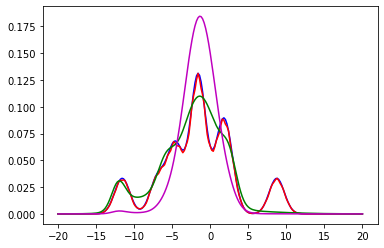

In [223]:
xplot = np.linspace(-20,20,201).reshape(-1,1)
yplot1 = logprob_mixgaussians(xplot).detach().numpy()
yplot2 = logprobgp.predict(xplot,return_cov=False).detach().numpy()
yplot3 = distrib.logprob(xplot).detach().numpy().reshape(-1,1)
yplot4 = distrib_fit.logprob(xplot).detach().numpy().reshape(-1,1)
plt.plot(xplot,np.exp(yplot1),'b')
plt.plot(xplot,np.exp(yplot2),'r')
plt.plot(xplot,np.exp(yplot3),'g')
plt.plot(xplot,np.exp(yplot4),'m')

In [114]:
alpha_relbo = 1e-1
maxiter_relbo = 100
alpha_boost = 1e-1
maxiter_boost = 100
maxiter = 20

mixmeans = torch.zeros(1,ndim)
mixvars = (20.0/3)**2*torch.ones(1,ndim)
mixweights = torch.ones(1)
for k in range(maxiter):
    mean0 = bvbq_torch.distributions.MixtureDiagonalNormalDistribution.sample_(1,mixmeans,mixvars,mixweights)[0,:]
    var0 = torch.distributions.HalfNormal(1.0).sample((ndim,))
    rawvar0 = torch.log(torch.exp(var0)-1)
    optimizer = torch.optim.Adam([mean0,rawvar0],alpha_relbo)
    mean0.requires_grad = True
    rawvar0.requires_grad = True
#     reg = torch.rand(1)
    for i in range(maxiter_relbo):
        optimizer.zero_grad()
        var0 = torch.log(torch.exp(rawvar0)+1)
        reg = torch.rand(1)
        relbo = bvbq_torch.bvbq_functions.mcbq_dmvn_relbo(logprobgp,mean0,var0,mixmeans,mixvars,mixweights,reg=reg)
        loss = -relbo
        loss.backward()
        optimizer.step()
    mean = mean0.detach()
    rawvar = rawvar0.detach()
    var = torch.log(torch.exp(rawvar)+1.0)
    weight = torch.tensor(1e-4)
    grad_term_logprob = bvbq_torch.bvbq_functions.logprob_terms_mixdmvn_delbodw(weight,
                                                                                logprobgp,
                                                                                mean,var,
                                                                                mixmeans,mixvars,
                                                                                mixweights)
    for j in range(maxiter_boost):
        grad_term_entropy = bvbq_torch.bvbq_functions.entropy_terms_mixdmvn_delbodw(weight,
                                                                                    mean,
                                                                                    var,
                                                                                    mixmeans,
                                                                                    mixvars,
                                                                                    mixweights,
                                                                                    nsamples=1000)
        grad = grad_term_logprob + grad_term_entropy
#         grad = bvbq_torch.bvbq_functions.mcbq_mixdmvn_delbodw(weight,
#                                                  logprobgp,
#                                                  mean,
#                                                  var,
#                                                  mixmeans,
#                                                  mixvars,
#                                                  mixweights,
#                                                  nsamples=1000)
        dweight = alpha_boost/(k+1)*grad
        weight += dweight
        weight = torch.clamp(weight,1e-4,1-1e-4)
    mixmeans = torch.vstack([mixmeans,mean])
    mixvars = torch.vstack([mixvars,var])
    mixweights = torch.hstack([(1-weight)*mixweights,weight])
    print(mean,var,weight)
# maxiter = kwargs.get("maxiter_nc",300)
# lr = kwargs.get("lr_nc",0.1)
# distrib_constant = kwargs.get("distrib_constant_nc",1.0)
# distrib_type = kwargs.get("distrib_type_nc","HN")
# verbose = kwargs.get("verbose",1)
# nsamples_nc = kwargs.get("n_samples_nc",100)
# if self.num_mixtures == 0:
#     raise NotImplementedError
# else:
#     mu0 = self._sample_from_current(1,flatten=True)
#     if distrib_type == "HN":
#         distrib = torch.distributions.HalfNormal
#     elif distrib_type == "HC":
#         distrib = torch.distributions.HalfCauchy
#     cov0 = distrib(torch.tensor([distrib_constant],device=self.device)).\
#                 sample((self.dim,)).flatten()
#     raw_cov0 = utils.invsoftplus(cov0)
#     theta0 = torch.cat([mu0,raw_cov0])
# theta0.requires_grad = True
# optimizer = torch.optim.Adam([theta0],lr=lr)
# for i in range(maxiter):
#     optimizer.zero_grad()
#     theta0.requires_grad = True
#     loss = self._evaluate_loss(theta0,nsamples=nsamples_nc,
#                               verbose=verbose)
#     if verbose >= 2:
#         print(theta0)
#         print(loss)
#     loss.backward()
#     optimizer.step()
# mu = theta0[:self.dim].detach()
# cov = (utils.softplus(theta0[self.dim:])).detach() #covariance
# if verbose >= 1:
#     print(loss)
# return mu,cov

tensor([-1.8494]) tensor([5.3815]) tensor(0.8990)
tensor([2.0048]) tensor([3.1706]) tensor(0.1299)
tensor([-1.3482]) tensor([5.6136]) tensor(0.0029)
tensor([1.7401]) tensor([2.0663]) tensor(0.0390)
tensor([-10.9139]) tensor([2.7418]) tensor(0.0958)
tensor([-1.8551]) tensor([7.7085]) tensor(0.0907)
tensor([-6.2333]) tensor([6.9744]) tensor(0.0973)
tensor([-5.9702]) tensor([3.8536]) tensor(0.0316)
tensor([-1.0034]) tensor([4.5969]) tensor(0.0452)
tensor([-1.0692]) tensor([6.5833]) tensor(0.0211)
tensor([-5.9536]) tensor([3.8636]) tensor(0.0142)
tensor([1.7541]) tensor([1.9203]) tensor(0.0578)
tensor([0.6453]) tensor([4.6178]) tensor(1.0000e-04)
tensor([1.2060]) tensor([2.9323]) tensor(0.0088)
tensor([-0.5237]) tensor([6.9446]) tensor(1.0000e-04)
tensor([-12.0143]) tensor([0.7385]) tensor(0.0366)
tensor([-2.1191]) tensor([4.8465]) tensor(0.0354)
tensor([-2.2351]) tensor([6.6327]) tensor(0.0243)
tensor([-5.8212]) tensor([4.3677]) tensor(0.0189)
tensor([-1.1525]) tensor([6.7064]) tensor(0.0

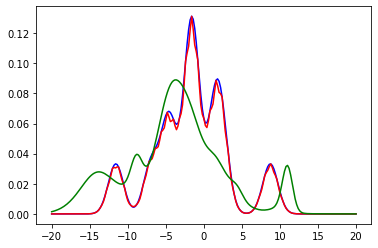

In [115]:
xplot = np.linspace(-20,20,201).reshape(-1,1)
yplot1 = logprob_mixgaussians(xplot).detach().numpy()
yplot2 = logprobgp.predict(xplot,return_cov=False).detach().numpy()
yplot3 = distrib.logprob(xplot).detach().numpy().reshape(-1,1)
plt.plot(xplot,np.exp(yplot1),'b')
plt.plot(xplot,np.exp(yplot2),'r')
plt.plot(xplot,np.exp(yplot3),'g')
